In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

# Load Data File

In [2]:
train = pd.read_csv('../input/kitchenware-classification/train.csv', dtype={'Id': str})
train['filename'] = train['Id'] + '.jpg'

test = pd.read_csv('../input/kitchenware-classification/test.csv', dtype={'Id': str})
test['filename'] =   test['Id'] + '.jpg'

train.head()

,Id,label,filename
0,0560,glass,0560.jpg
1,4675,cup,4675.jpg
2,0875,glass,0875.jpg
3,4436,spoon,4436.jpg
4,8265,plate,8265.jpg


In [3]:
# target variable - encoding numeric value
label_list = train['label'].tolist()
label_numeric = {k:v+1 for v,k in enumerate(set(label_list))}
y_train = [label_numeric[k] for k in label_list]     
train['label'] = y_train
train['label'] = train['label'].astype(str)
train.head()

,Id,label,filename
0,0560,3,0560.jpg
1,4675,2,4675.jpg
2,0875,3,0875.jpg
3,4436,1,4436.jpg
4,8265,4,8265.jpg


In [4]:
label_numeric

{'spoon': 1, 'cup': 2, 'glass': 3, 'plate': 4, 'fork': 5, 'knife': 6}

In [5]:
print('The train data has {} images '.format(train.shape[0]))
print('The test data has {}  images '.format(test.shape[0]))

The train data has 5559 images 
The test data has 3808  images 


In [6]:
print('The train data has {} unique labels'.format(train['label'].nunique()))

The train data has 6 unique labels


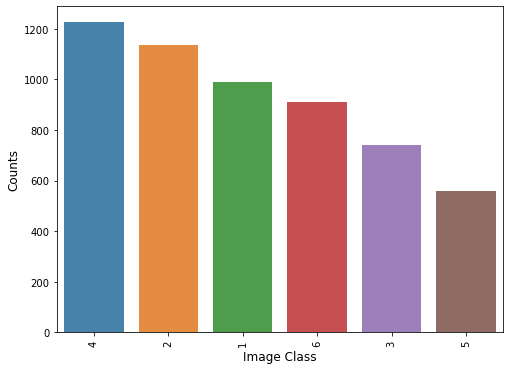

In [7]:
label_counts = train.label.value_counts()
plt.figure(figsize = (8,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Class', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [8]:
src_path_train = "/kaggle/input/kitchenware-classification/images/"
src_path_test = "/kaggle/input/kitchenware-classification/images/"


train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [9]:
batch_size = 16
IMAGE_SHAPE = (300, 300)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=src_path_train,
    x_col="filename",
    y_col="label",
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=src_path_train,
    x_col="filename",
    y_col="label",
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)


Found 4448 validated image filenames belonging to 6 classes.
Found 1111 validated image filenames belonging to 6 classes.


In [10]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=src_path_test,
    x_col="filename",
    target_size=(300, 300),
    batch_size=16,
    class_mode=None,
    shuffle=False,
)

Found 3808 validated image filenames.


# EfficientNet Model

In [11]:
# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1"

def create_model(model_url, num_classes=6):
    feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,                  # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape= IMAGE_SHAPE+(3,))    # define the input image shape
  
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
      ])
    return model

In [12]:
# Create model
model = create_model(model_url=efficientnet_url,num_classes=6)

# Compile EfficientNet model
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

2023-02-01 14:37:59.754304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 14:37:59.755306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 14:37:59.945306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 14:37:59.946264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 14:37:59.947025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

# Train The Model

In [13]:
# fit the model
history = model.fit(train_generator,
                    epochs=5,
                    steps_per_epoch=len(train_generator),
                    validation_data=valid_generator,  
                    validation_steps=len(valid_generator)) 

2023-02-01 14:38:19.703135: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2023-02-01 14:38:35.057162: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


278/278 [==============================] - 271s 886ms/step - loss: 0.2946 - accuracy: 0.9272 - val_loss: 0.1345 - val_accuracy: 0.9604
Epoch 2/5
278/278 [==============================] - 189s 681ms/step - loss: 0.1260 - accuracy: 0.9609 - val_loss: 0.1167 - val_accuracy: 0.9622
Epoch 3/5
278/278 [==============================] - 191s 689ms/step - loss: 0.0969 - accuracy: 0.9710 - val_loss: 0.1145 - val_accuracy: 0.9631
Epoch 4/5
278/278 [==============================] - 189s 680ms/step - loss: 0.0843 - accuracy: 0.9759 - val_loss: 0.1253 - val_accuracy: 0.9568
Epoch 5/5
278/278 [==============================] - 191s 689ms/step - loss: 0.0740 - accuracy: 0.9777 - val_loss: 0.1105 - val_accuracy: 0.9658


# Accuracy and Loss

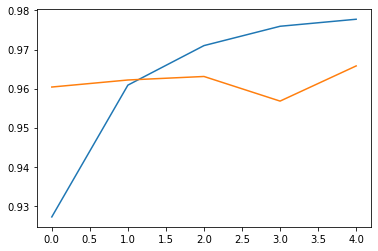

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

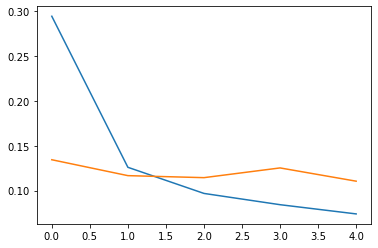

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [16]:
score = model.evaluate_generator(valid_generator)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11011441051959991
Test accuracy: 0.9576957821846008


# Prediction on Test Data

In [17]:
predict = model.predict_generator(test_generator, steps = len(test_generator.filenames))

In [18]:
predict[:5]

array([[6.7240548e-01, 4.0530185e-03, 3.2043641e-03, 3.9144959e-03,
        1.1053412e-02, 3.0536929e-01],
       [4.9837636e-05, 9.4222087e-06, 7.9269284e-06, 6.1383562e-06,
        3.3089137e-04, 9.9959582e-01],
       [1.0438297e-02, 2.6333180e-05, 5.2151410e-04, 5.9813414e-05,
        9.8012036e-01, 8.8336561e-03],
       [4.2845263e-06, 1.8730176e-04, 1.8667798e-04, 9.9956316e-01,
        3.7690425e-06, 5.4692147e-05],
       [5.7482310e-03, 2.4418391e-06, 2.3433575e-05, 6.2318404e-06,
        9.9412268e-01, 9.6919153e-05]], dtype=float32)

In [19]:
y_classes = predict.argmax(axis=-1)
print(y_classes)

[0 5 4 ... 0 4 0]


In [20]:
rev_y = {v:k for k,v in label_numeric.items()}
pred_labels = [rev_y[k+1] for k in y_classes]
pred_labels[:5]

['spoon', 'knife', 'fork', 'plate', 'fork']

In [21]:
# make submission
submission = pd.DataFrame({'id':test['Id'], 'label':pred_labels})
submission.to_csv('submission1.csv', index=False)

In [22]:
submission.head()

,id,label
0,0678,spoon
1,3962,knife
2,9271,fork
3,5133,plate
4,8842,fork
